# 로드뷰 사진을 통해 서울 시내의 범죄 위험도를 예측할 수 있을까?

- **연구 주제**
  - 로드뷰 사진을 통해 서울 시내의 범죄 위험도를 알 수 있을까?
  - 그것이 가능하다면, 로드뷰로 해당 도로의 범죄 위험도를 예측하고 위험한 지역의 건물이나 가로등 등의 지형지물을 수리함으로써 범죄를 예방할 수 있지 않을까?

- **주제 선정 동기**
>  범죄에 큰 관심이 없더라도 한번쯤은 들어봤을 법한 "깨진 유리창 이론"을 떠올리며 주제를 떠올리게 되었습니다. 깨진 유리창 하나를 방치해 두면 그 지점을 중심으로 범죄가 확산되기 시작한다고 주장하는 깨진 유리창 이론은 사소한 무질서를 방치하면 큰 문제로 이어질 가능성이 높다는 것을 시사하는 한편, 범죄가 발생하는 장소에 초점을 맞추고 있습니다. 범죄의 한 장면을 상상해보라 하면 많은 사람들이 쉽게 떠올릴 법한 장소와 그 느낌이 있다고 생각했고, 그러한 장소와 그 장소의 느낌을 바꾸어주면 범죄를 예방할 수 있을 것이라는 생각으로 연구를 시작하게 되었습니다.   
실제로 범죄학의 이론으로도 정립되어 있었는데, 일상활동이론(cohen & felson, 1979)에 따르면 범죄는 동기가 부여된 범죄자가 보호자가 없는 적절한 피해자를 시간과 공간적으로 동시에 만날 때 발생한다고 합니다. 즉, 범죄 발생에 있어서 장소의 역할이 매우 중요합니다. 범죄성(criminality)을 가진 범죄자들은 범죄에 대한 동기가 크게 부여되어 있을 수 있지만, 항상 범죄를 저지르는 것은 아닙니다. 따라서 어떠한 '상황'이, '장소'가 그들로 하여금 범죄를 저지르게 하는지 또는 억제하는지를 살펴보는 것은 중요하고 장소나 건물의 디자인을 변경함으로써 범죄율을 줄일 수 있을 것이라 생각하였습니다. 

- **연구 진행 순서**

  **1. 데이터 수집**
> 1) QGIS에서 구 레이어 안의 랜덤포인트를 200개씩 생성한 뒤, 해당 랜덤포인트의 위도, 경도를 카카오맵 사이트에 넣으며 로드뷰 사진 크롤링 (총 5000개)  
2) 해당 위도, 경도에 로드뷰가 없어 기본화면이 저장된 경우 등을 포함하여 의미 없는 사진을 삭제한 뒤, 필요한 부분만 정사각형으로 자름 (최종 데이터 개수 2663개)  
3) 서울 열린데이터광장(https://data.seoul.go.kr/) 에서 2014년 ~ 2020년 구 단위 데이터 수집(건강보험대상자 진료실적, 서울시 유흥주점 영업 인허가 정보, 어린이 보호구역 위치도, 방범용 cctv 현황 등 24개 데이터 셋 활용)  
4) 24개의 데이터 테이블에서 필요한 정보들을 추출하여 저장하는 방식으로 raw_2014 ~ raw_2020 엑셀파일 생성 
  - row : 175 (7개년 x 25개 구)
  - columns : 46 (5대 범죄 발생횟수 및 여러 구 데이터 40개)

  **2. XGBoost**
> 1) Regression : 5대 범죄 합계 발생횟수를 target으로 하여 40개의 변수로 regression 진행 -> feature importance 살펴 봄  
2) Classification : 5대 범죄 합계 발생횟수 상위 50%는 unsafe, 하위 50%는 safe로 하여 이진분류 모델 학습 -> feature importance 살펴 봄  
3) feature importance 상위 12개 변수 : 출동건수_기타활동, 유통업체 개수, 노년부양비, 인구, 인구이동(전출), 등록외국인, 기초생활보장 수급자, 65세 이상 인구, 유흥주점 개수, 인구밀도, 시장 개수, 방범용 cctv 개수 -> 이후 앙상블 모델에서 활용

  **3. CNN**
> 1) 레이블 생성 : 7개년 중 4개년 이상 5대 범죄 합계 발생횟수가 상위 50%였던 12개의 구를 unsafe, 나머지를 safe로 label 생성  
2) 이후 앙상블 모델에서 CNN 결과 레이블이 필요하기 때문에 전체 데이터의 50%만 학습에 활용하고 50%는 예측에 활용  
3) pretrained resnet18을 활용하여 CNN 모델 학습

  **4. Ensemble**
> 위에서 CNN을 학습시켜 나온 결과 및 XGBoost로 얻은 주요 변수 12개로 범죄 위험도를 예측하는 앙상블 모델(로지스틱 회귀) 생성  

# 1. Install and Import Libraries

In [1]:
# import up-to-date xgboost

!pip uninstall --yes xgboost # remove xgboost 0.90
!pip install xgboost # install 1.6.1

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 64 kB/s 


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,618 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [3]:
# upgrade fastai to the most recent version (v. 2.6.3)

%%capture
!pip install fastai --upgrade

In [4]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

2.6.3


In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
from collections import Counter

import xgboost as xgb
from xgboost import cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression

# 한글 깨짐 문제 해결
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'NanumBarunGothic')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load Data

서울시의 5대 범죄 데이터는 2014년부터 2020년까지 있기 때문에 구 단위로 2014년 ~ 2020년이 있는 데이터로 사용했습니다. 사용한 서울시 데이터는 다음과 같습니다. 해당 데이터 테이블에서 필요한 정보들을 추출하여 사용하는 방식을 취했기 때문에 빈 엑셀파일에 각 데이터에서 필요한 정보들을 가져오는 방식으로 진행하였고, 그 결과 raw_2014 ~ raw_2020 이라는 엑셀 파일들을 만들었습니다.  
  - 건강보험대상자 진료실적
  - 서울시 유흥주점 영업 인허가 정보
  - 어린이 보호구역 위치도
  - 방범용 cctv 현황
  - 서울시 cctv 설치 운영현황(목적별)
  - 자치구별 횡단보도와 신호등 개수 
  - 공무원 1인당 담당인구
  - 서울시 119 구조활동 실적
  - 서울시 고령자 현황
  - 서울시 국민기초생활보장 수급자
  - 서울시 등록외국인 현황
  - 서울시 부양비 및 노령화 지수
  - 서울시 빈집 현황
  - 서울시 시내 주요기관 (경찰서, 소방서 개수)
  - 서울시 시장 현황
  - 서울시 여성가구주 현황
  - 서울시 유통업체 현황
  - 서울시 의료기관 현황
  - 서울시 인구밀도 통계
  - 서울시 주민등록 전입지별 인구이동
  - 서울시 주민등록 전출지별 인구이동
  - 서울시 행정구역 통계
  - 소방서 1개소당 담당인구
  - 서울시 지방세 징수


In [7]:
data_2014 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2014.xlsx')
data_2015 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2015.xlsx')
data_2016 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2016.xlsx')
data_2017 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2017.xlsx')
data_2018 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2018.xlsx')
data_2019 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2019.xlsx')
data_2020 = pd.read_excel('/content/drive/MyDrive/AI 경제정보처리/HW3/raw_2020.xlsx')

In [8]:
# 2014년 ~ 2020년 데이터 concat
data = pd.concat([data_2014, data_2015, data_2016, data_2017, data_2018, data_2019, data_2020])
data.reset_index(inplace=True)
data.drop(['index'],axis=1,inplace=True)
data

,자치구,5대 범죄 합계,살인,강도,강간강제추행,절도,폭력,건강보험 지급건수,공무원1인당 담당인구,인구,...,인구이동(전출),횡단보도 개수,신호등 개수,어린이보호구역,cctv 개수,방범용 cctv 개수,경찰서,지구대파출소치안센터,119안전센터,유흥주점 개수
0,종로구_2014,5021.0,3.0,12.0,226.0,2272.0,2508.0,4190373.0,140.7,165344.0,...,27484.0,1094.0,626.0,38.0,6502.0,935.0,2.0,23.0,6.0,435.0
1,중구_2014,5231.0,6.0,13.0,221.0,2576.0,2415.0,3397782.0,112.5,136227.0,...,22972.0,1366.0,636.0,33.0,2854.0,363.0,2.0,18.0,5.0,648.0
2,용산구_2014,3799.0,1.0,7.0,213.0,1560.0,2018.0,5600674.0,206.7,249914.0,...,40635.0,1066.0,659.0,33.0,4942.0,1398.0,1.0,12.0,5.0,88.0
3,성동구_2014,3582.0,1.0,5.0,141.0,1753.0,1682.0,7682710.0,253.5,303891.0,...,51349.0,1170.0,697.0,44.0,2560.0,1089.0,1.0,15.0,4.0,33.0
4,광진구_2014,6268.0,8.0,16.0,249.0,3167.0,2828.0,9134048.0,329.9,377375.0,...,64189.0,1008.0,625.0,80.0,2497.0,638.0,1.0,10.0,3.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,관악구_2020,5261.0,12.0,3.0,403.0,2229.0,2614.0,11340409.0,339.0,509803.0,...,103226.0,975.0,695.0,65.0,2588.0,4071.0,1.0,19.0,4.0,405.0
171,서초구_2020,4601.0,5.0,6.0,396.0,2021.0,2173.0,9045831.0,273.3,429025.0,...,77669.0,2028.0,1168.0,56.0,3312.0,3175.0,2.0,19.0,6.0,291.0
172,강남구_2020,7356.0,6.0,14.0,708.0,2951.0,3677.0,11225500.0,315.8,544055.0,...,101582.0,2688.0,1377.0,100.0,1772.0,5796.0,2.0,21.0,6.0,651.0
173,송파구_2020,5410.0,6.0,13.0,287.0,2429.0,2675.0,15334191.0,399.7,673926.0,...,116457.0,2185.0,1516.0,83.0,2374.0,2372.0,1.0,21.0,6.0,202.0


In [9]:
# NaN 개수 확인
data.isnull().sum()

자치구                  0
5대 범죄 합계             0
살인                   0
강도                   0
강간강제추행               0
절도                   0
폭력                   0
건강보험 지급건수            0
공무원1인당 담당인구          0
인구                   0
출동건수_합계              0
출동건수_인명구조            0
출동건수_안전조치            0
출동건수_기타활동            0
출동건수_미처리(자체처리허위등)    0
사상_합계                0
사상_사망                0
사상_부상                0
사상_기타                0
65세 이상 인구            0
기초생활보장 수급자           0
등록외국인                0
유년부양비                0
노년부양비                0
노령화지수                0
빈집 개수                0
시장 개수                0
시장 점포수               0
여성가구주 가구 비율          0
유통업체 개수              0
병원수                  0
병상수                  0
면적                   0
인구밀도(명/㎢)            0
소방서 1개소당 담당인구        0
지방세                  0
인구이동(전입)             0
인구이동(전출)             0
횡단보도 개수              0
신호등 개수               0
어린이보호구역              0
cctv 개수              0
방범용 cctv 개수          0
경찰서        

## Heatmap

변수가 너무 많았기 때문에 각 변수들 간의 상관관계를 보기 위해 heatmap을 그려보았습니다. 눈에 띄었던 변수들의 상관관계를 간단하게 언급해보자면 다음과 같습니다. 
- 노령화지수(=노년부양비)는 각종 범죄들이나 119 출동 건수와 강한 음의 상관관계를 갖습니다. 이것으로 보아 노인층이 많이 사는 동네는 범죄가 덜 일어나며 각종 사건, 사고도 적게 일어난다는 것을 추측할 수 있습니다. 
- 인구는 공무원 1인당 담당인구, 건강보험 지급건수, 인구의 전출입, 신호등/횡단보도 개수 등과 강한 양의 상관관계를 갖습니다. 이것은 우리의 직관과도 잘 맞는 것 같습니다. 

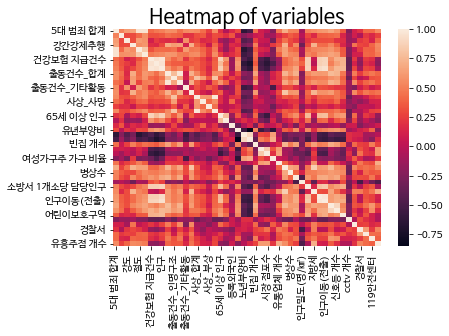

In [9]:
temp = data.copy()
temp.drop(['자치구'], axis=1, inplace=True)
temp_corr = temp.corr()
sns.heatmap(temp_corr)
plt.title('Heatmap of variables', fontsize=20)
plt.show()

# XGBoost

5대 범죄 합계 및 5대 범죄 각각의 변수들을 제거해도 대략 40개의 변수가 있는데, 이것이 너무 많다고 생각하여 XGBoost로 Feature Importance를 보려 했습니다. XGBoost의 성능이 너무 뛰어나 이미지 없이 40여개의 변수로만 regression, classification을 진행하여도 R^2가 0.839, accuracy는 0.971이 나옵니다. 

## Split Train & Test Set

In [10]:
X = data.drop(['5대 범죄 합계','자치구','살인','강도','폭력','절도','강간강제추행'],axis=1)
y = data[['5대 범죄 합계']]
print(X.shape, y.shape)

(175, 40) (175, 1)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(140, 40) (35, 40) (140, 1) (35, 1)


## XGB - Regression

5대 범죄의 합계를 target으로 하여 regression을 진행하였습니다. regression을 하였을 때 feature importance가 높게 나오는 변수는 건강보험 지급건수, 출동건수_기타활동, 출동건수_합계, 노년부양비 등이었습니다. 

In [15]:
# set XGBoost regressor parameters

params = {'objective':'reg:squarederror', 
          'random_state':42, 'nthread':-1, 'n_estimators':300,
          'eta':0.1
        }
xgb_reg = xgb.XGBRegressor(**params)

In [16]:
early_stop_rounds = 20

# use early stopping

xgb_reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-rmse:4136.43290
[1]	validation_0-rmse:3771.07800
[2]	validation_0-rmse:3428.86274
[3]	validation_0-rmse:3121.23176
[4]	validation_0-rmse:2842.87807
[5]	validation_0-rmse:2600.53835
[6]	validation_0-rmse:2386.50572
[7]	validation_0-rmse:2199.35631
[8]	validation_0-rmse:2026.92974
[9]	validation_0-rmse:1859.05578
[10]	validation_0-rmse:1715.36845
[11]	validation_0-rmse:1589.75668
[12]	validation_0-rmse:1480.24708
[13]	validation_0-rmse:1368.93980
[14]	validation_0-rmse:1271.48055
[15]	validation_0-rmse:1178.97772
[16]	validation_0-rmse:1103.49245
[17]	validation_0-rmse:1028.91408
[18]	validation_0-rmse:969.16719
[19]	validation_0-rmse:906.37802
[20]	validation_0-rmse:845.01588
[21]	validation_0-rmse:794.37492
[22]	validation_0-rmse:757.57916
[23]	validation_0-rmse:724.43593
[24]	validation_0-rmse:696.43465
[25]	validation_0-rmse:667.01356
[26]	validation_0-rmse:646.11144
[27]	validation_0-rmse:627.50350
[28]	validation_0-rmse:609.37622
[29]	validation_0-rmse:594.63372
[3

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
             random_state=42, ...)

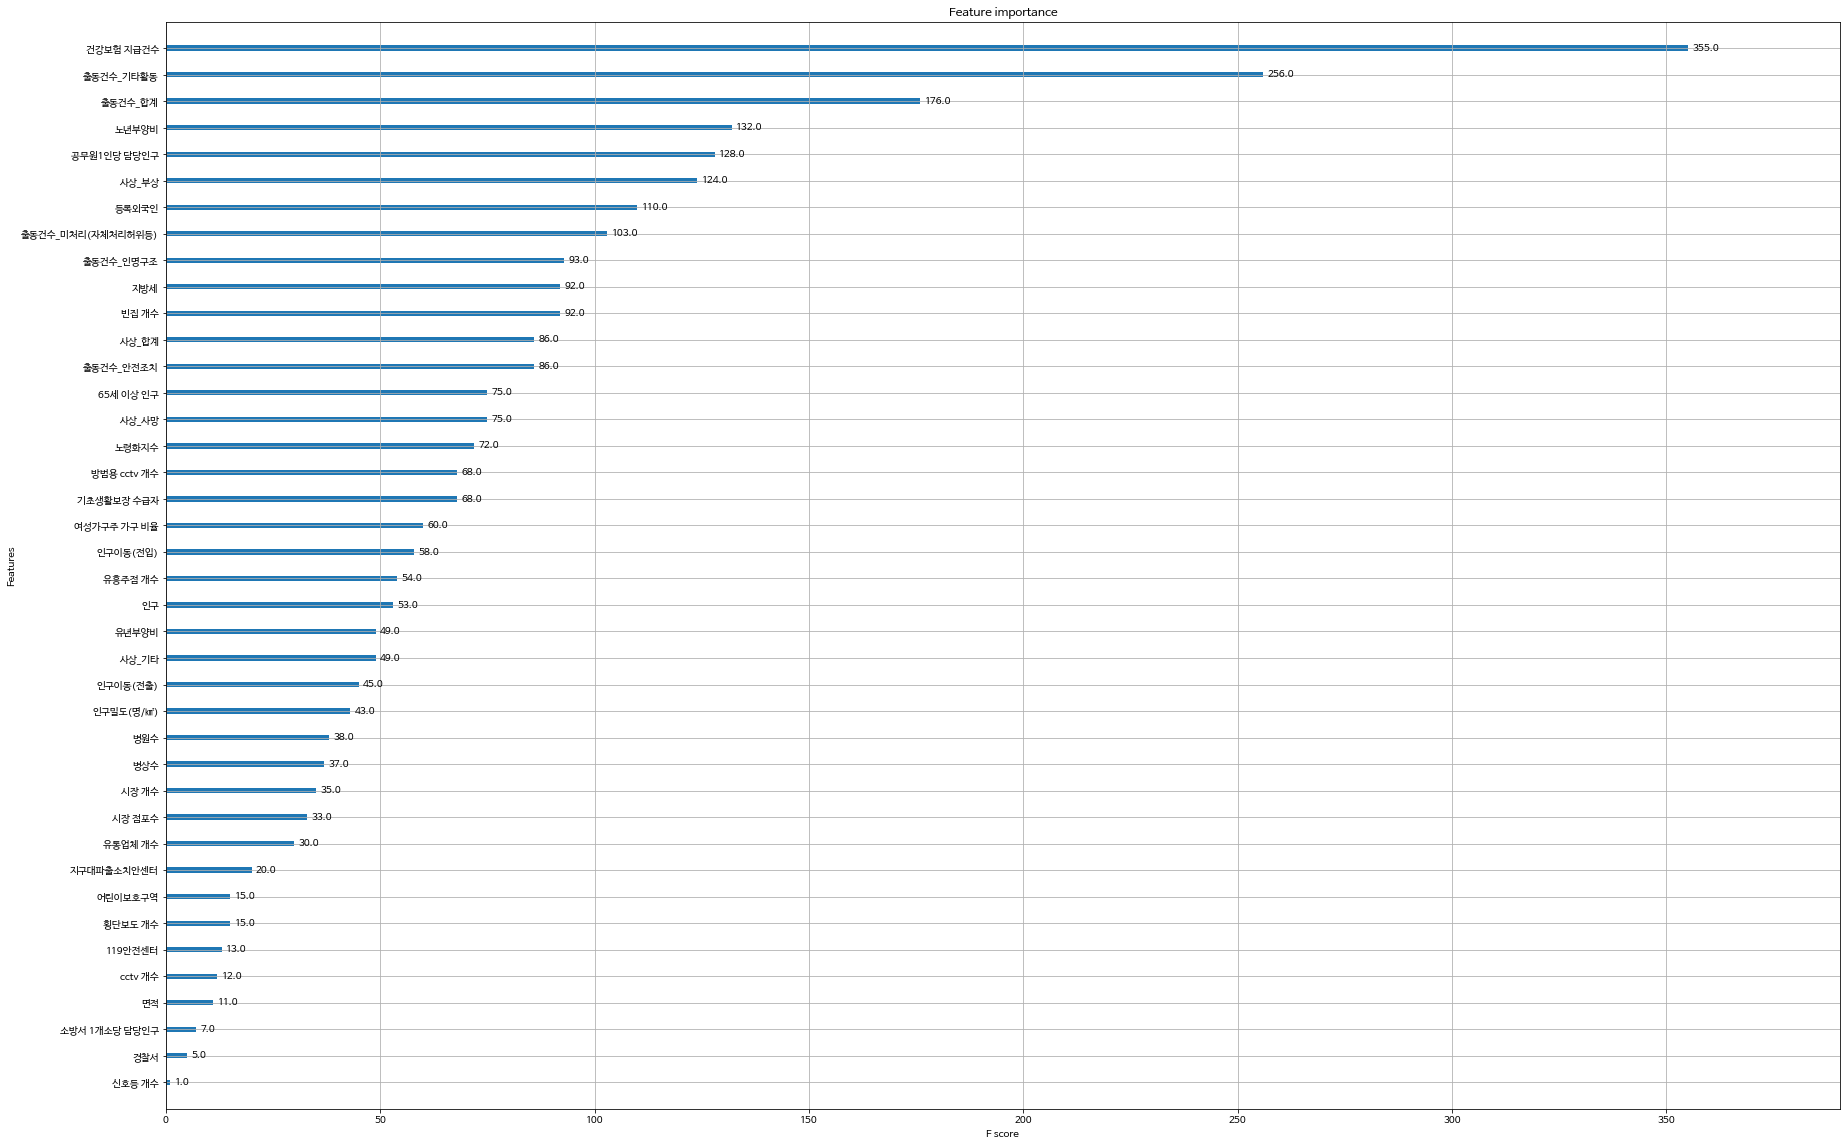

In [17]:
# Feautre Importance

ax = xgb.plot_importance(xgb_reg)
fig = ax.figure
#plt.rc('font', family='NanumBarunGothic')
fig.set_size_inches(30,20)

In [18]:
y_preds = xgb_reg.predict(X_test)
y_preds

array([3441.2925, 5150.386 , 4044.5398, 3433.7957, 4416.949 , 3835.0642,
       3660.3477, 6024.4756, 3907.5742, 5555.453 , 3207.2063, 4639.1406,
       6170.4316, 3892.989 , 4753.453 , 3313.9072, 4580.631 , 4024.6396,
       5943.2617, 3572.9194, 4462.1284, 2680.142 , 2490.5059, 5165.3276,
       4772.085 , 4647.3804, 2071.563 , 4728.1436, 5013.254 , 3062.9272,
       4000.291 , 6710.5884, 3898.4531, 4636.947 , 3272.832 ],
      dtype=float32)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r_squared = r2_score(y_test, y_preds)
print("RMSE: %.3f" % (rmse))
print('R^2: %.3f' %r_squared)

RMSE: 463.220
R^2: 0.839


In [20]:
preds = y_preds.tolist()
targs = np.array(y_test).tolist()

In [21]:
df_plot1 = pd.DataFrame(targs, columns=['target'])
df_plot2 = pd.DataFrame(preds, columns=['predicted'])
df_plot = pd.concat([df_plot1,df_plot2], axis=1)
df_plot.head()

,target,predicted
0,3726.0,3441.292480
1,5328.0,5150.386230
2,4030.0,4044.539795
3,3313.0,3433.795654
4,4707.0,4416.949219


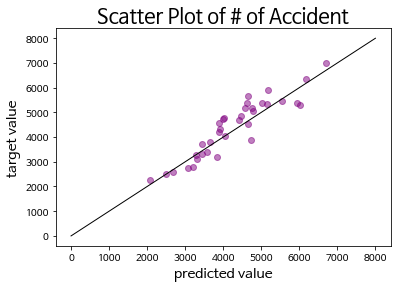

In [22]:
plt.plot('predicted',  ## x
         'target',  ## y
         data=df_plot,
         linestyle='none', ## 선으로 그리지 않음 -> scatter
         marker='o', ## 동그라미 점으로
         markersize=6,
         color='purple', 
         alpha=0.5) ## 투명도 50% (1: 불투명, 0: 투명)
plt.title('Scatter Plot of # of Accident', fontsize=20)
plt.xlabel('predicted value', fontsize=14)
plt.ylabel('target value', fontsize=14)
#plt.axis([1, 10, 1, 10])
plt.plot([0, 8000], [0, 8000], color = 'black', linewidth = 1)
plt.show()

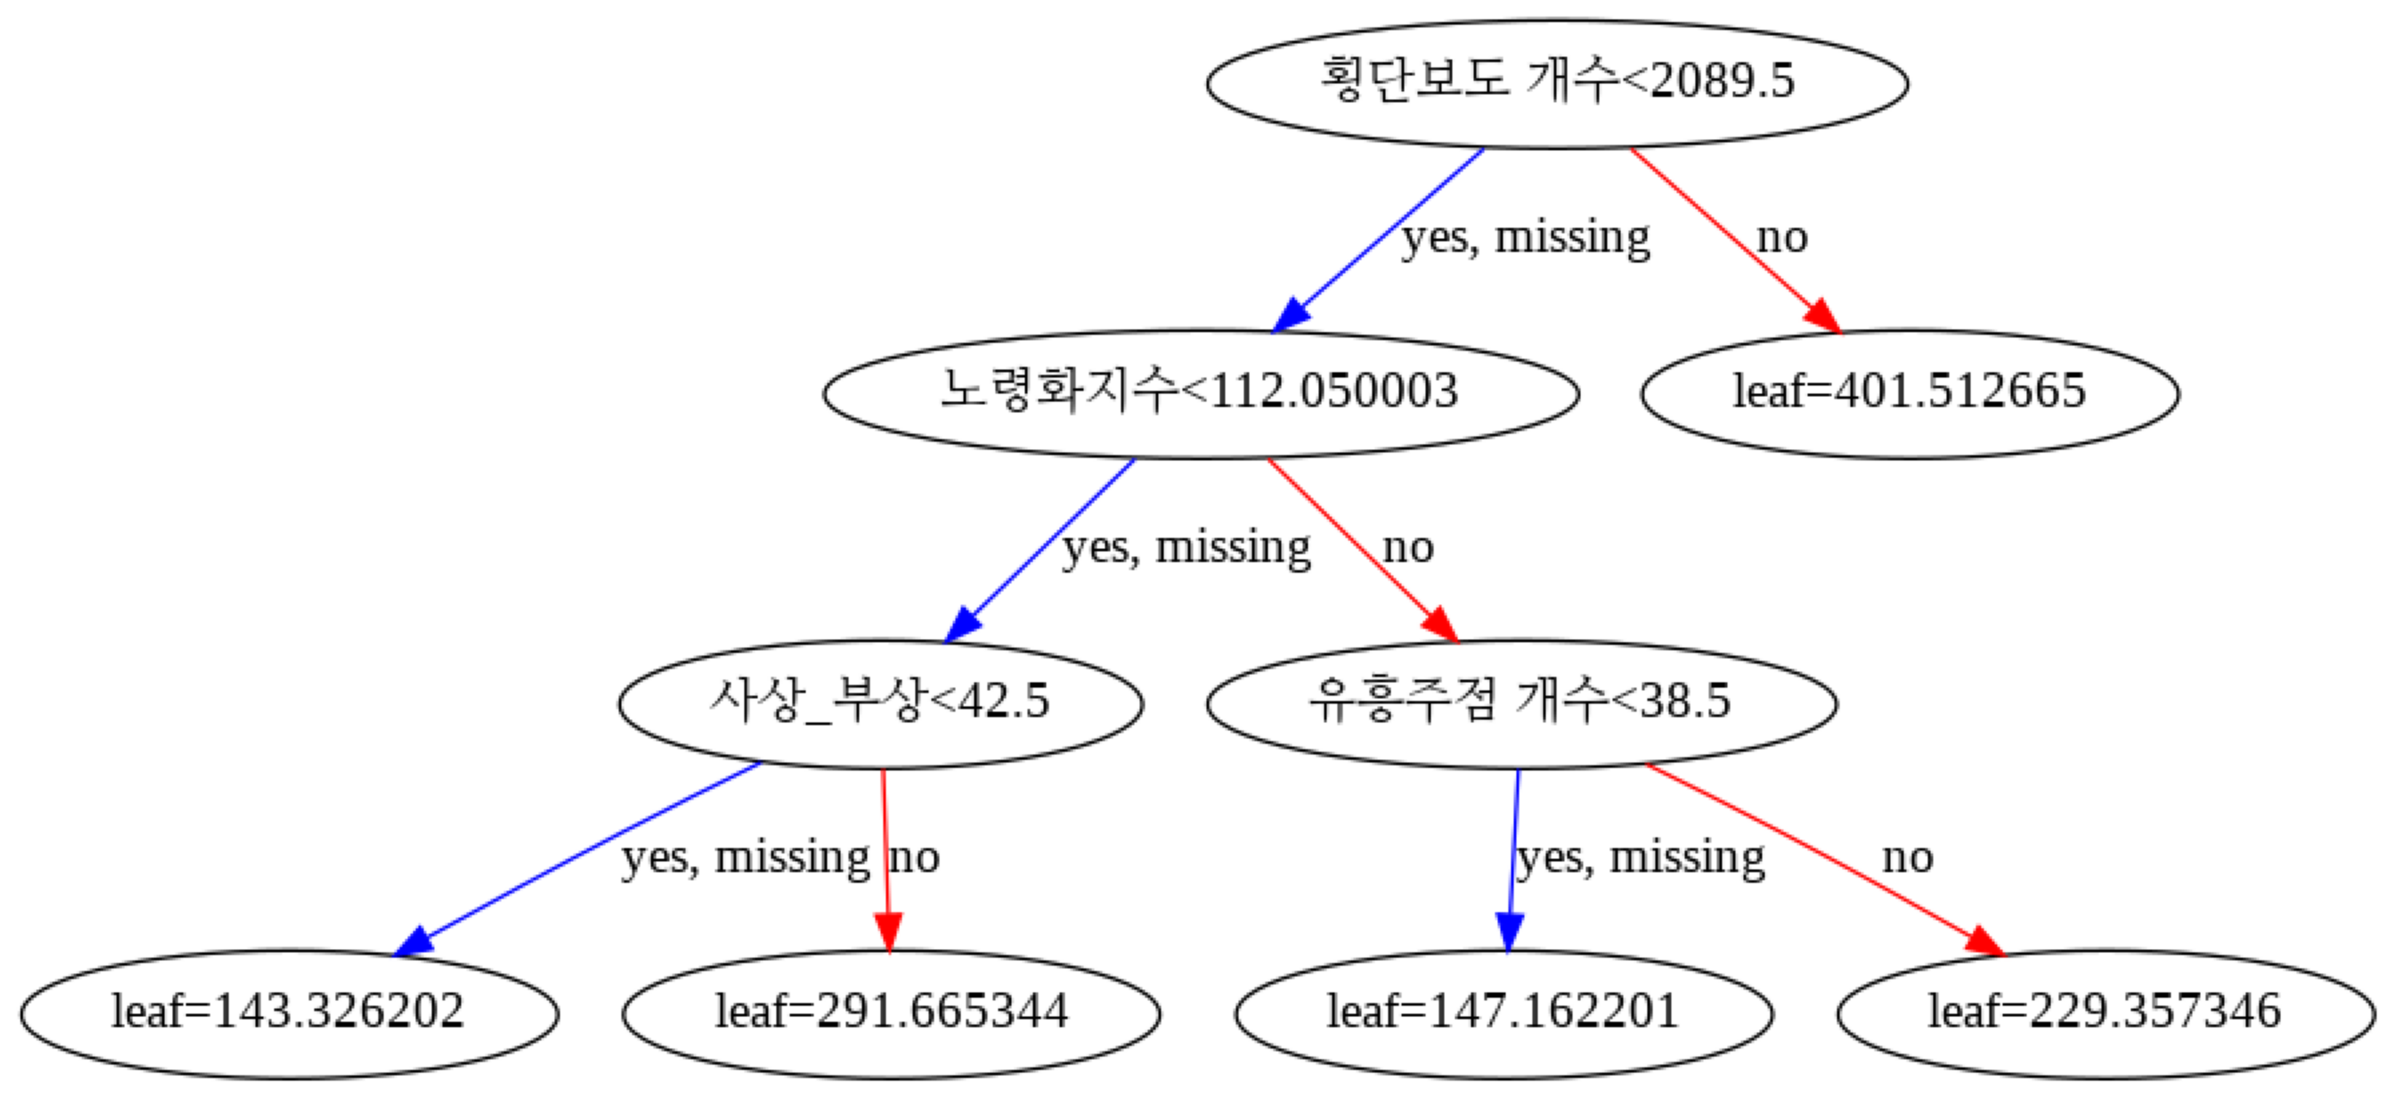

In [36]:
xgb.plot_tree(xgb_reg,num_trees=5)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

## XGB - Classification

5대 범죄 합계 변수를 바탕으로 범죄위험도라는 변수를 만들었습니다. 범죄위험도 변수는 5대 범죄 합계의 상위 50%에 대해 unsafe, 그렇지 않은 것에 safe을 붙여주어 만들었습니다. 이 분류기의 정확도는 0.971로 상당히 좋은 예측력을 보였으며 변수 중요도가 높은 변수로는 출동건수_기타활동, 유통업체 개수, 노년부양비, 인구, 인구이동(전출), 등록외국인, 기초생활보장 수급자, 유흥주점 개수, 방범용 cctv 개수 등이 있습니다. 

### Make Labels & Split Train/Test Set

In [9]:
q = np.quantile(data['5대 범죄 합계'], [0.5])
data['범죄위험도'] = 'safe'
data.loc[data['5대 범죄 합계']>q[0], '범죄위험도'] = 'unsafe'
data

,자치구,5대 범죄 합계,살인,강도,강간강제추행,절도,폭력,건강보험 지급건수,공무원1인당 담당인구,인구,...,횡단보도 개수,신호등 개수,어린이보호구역,cctv 개수,방범용 cctv 개수,경찰서,지구대파출소치안센터,119안전센터,유흥주점 개수,범죄위험도
0,종로구_2014,5021.0,3.0,12.0,226.0,2272.0,2508.0,4190373.0,140.7,165344.0,...,1094.0,626.0,38.0,6502.0,935.0,2.0,23.0,6.0,435.0,unsafe
1,중구_2014,5231.0,6.0,13.0,221.0,2576.0,2415.0,3397782.0,112.5,136227.0,...,1366.0,636.0,33.0,2854.0,363.0,2.0,18.0,5.0,648.0,unsafe
2,용산구_2014,3799.0,1.0,7.0,213.0,1560.0,2018.0,5600674.0,206.7,249914.0,...,1066.0,659.0,33.0,4942.0,1398.0,1.0,12.0,5.0,88.0,safe
3,성동구_2014,3582.0,1.0,5.0,141.0,1753.0,1682.0,7682710.0,253.5,303891.0,...,1170.0,697.0,44.0,2560.0,1089.0,1.0,15.0,4.0,33.0,safe
4,광진구_2014,6268.0,8.0,16.0,249.0,3167.0,2828.0,9134048.0,329.9,377375.0,...,1008.0,625.0,80.0,2497.0,638.0,1.0,10.0,3.0,26.0,unsafe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,관악구_2020,5261.0,12.0,3.0,403.0,2229.0,2614.0,11340409.0,339.0,509803.0,...,975.0,695.0,65.0,2588.0,4071.0,1.0,19.0,4.0,405.0,unsafe
171,서초구_2020,4601.0,5.0,6.0,396.0,2021.0,2173.0,9045831.0,273.3,429025.0,...,2028.0,1168.0,56.0,3312.0,3175.0,2.0,19.0,6.0,291.0,unsafe
172,강남구_2020,7356.0,6.0,14.0,708.0,2951.0,3677.0,11225500.0,315.8,544055.0,...,2688.0,1377.0,100.0,1772.0,5796.0,2.0,21.0,6.0,651.0,unsafe
173,송파구_2020,5410.0,6.0,13.0,287.0,2429.0,2675.0,15334191.0,399.7,673926.0,...,2185.0,1516.0,83.0,2374.0,2372.0,1.0,21.0,6.0,202.0,unsafe


In [25]:
X2 = data.drop(['범죄위험도','5대 범죄 합계','자치구','살인','강도','폭력','절도','강간강제추행'],axis=1)
y2 = data[['범죄위험도']]
print(X2.shape, y2.shape)

(175, 40) (175, 1)


In [26]:
print(y2.value_counts())

le = LabelEncoder()
y_dummy = le.fit_transform(data['범죄위험도'])
y_dummy = pd.DataFrame(y_dummy)

le.classes_

범죄위험도 
safe      88
unsafe    87
dtype: int64


array(['safe', 'unsafe'], dtype=object)

In [27]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X2, y_dummy, stratify=y_dummy, test_size=0.2, random_state = 42)
print(X_train_clf.shape, X_test_clf.shape, y_train_clf.shape, y_test_clf.shape)

(140, 40) (35, 40) (140, 1) (35, 1)


### Classification

In [28]:
params = {'objective':'binary:logistic', 'eval_metric':'error',
          'random_state':42, 'nthread':-1, 'n_estimators':300,
        }

xgb_classify = xgb.XGBClassifier(**params)

In [29]:
early_stop_rounds = 20

# use early stopping

xgb_classify.fit(X_train_clf, y_train_clf,
            eval_set=[(X_test_clf, y_test_clf)], early_stopping_rounds=early_stop_rounds)

[0]	validation_0-error:0.02857
[1]	validation_0-error:0.11429
[2]	validation_0-error:0.08571
[3]	validation_0-error:0.05714
[4]	validation_0-error:0.05714
[5]	validation_0-error:0.05714
[6]	validation_0-error:0.08571
[7]	validation_0-error:0.08571
[8]	validation_0-error:0.08571
[9]	validation_0-error:0.08571
[10]	validation_0-error:0.08571
[11]	validation_0-error:0.08571
[12]	validation_0-error:0.11429
[13]	validation_0-error:0.11429
[14]	validation_0-error:0.11429
[15]	validation_0-error:0.08571
[16]	validation_0-error:0.08571
[17]	validation_0-error:0.08571
[18]	validation_0-error:0.08571
[19]	validation_0-error:0.08571


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)

In [30]:
y_preds_clf = xgb_classify.predict(X_test_clf)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_clf, y_preds_clf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.94      0.97        17

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35



In [53]:
# confusion matrix plot

import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    plt.figure(figsize=(12, 9))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

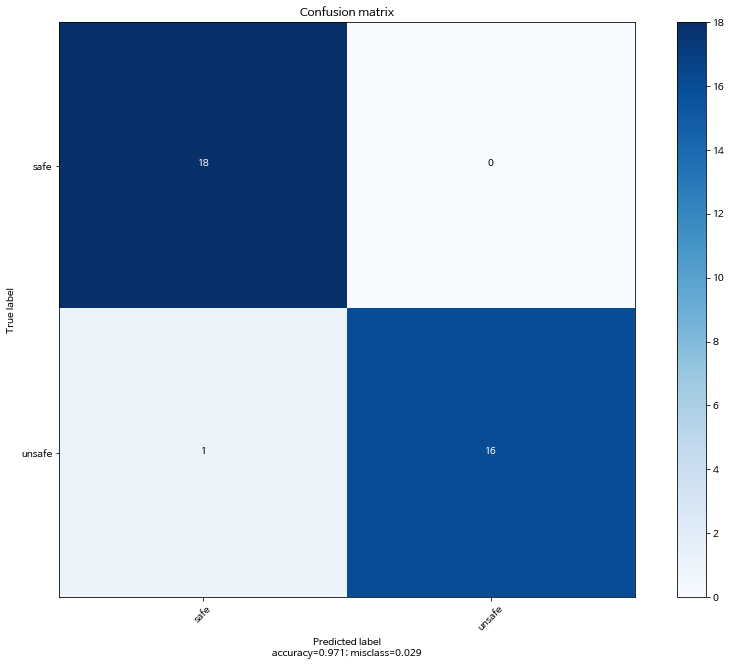

In [33]:
# confusion matrics

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_clf, y_preds_clf)

# plot confusion matrix (raw)

my_classes = ['safe','unsafe']

plot_confusion_matrix(conf_mx, my_classes, cmap=None, normalize=False)

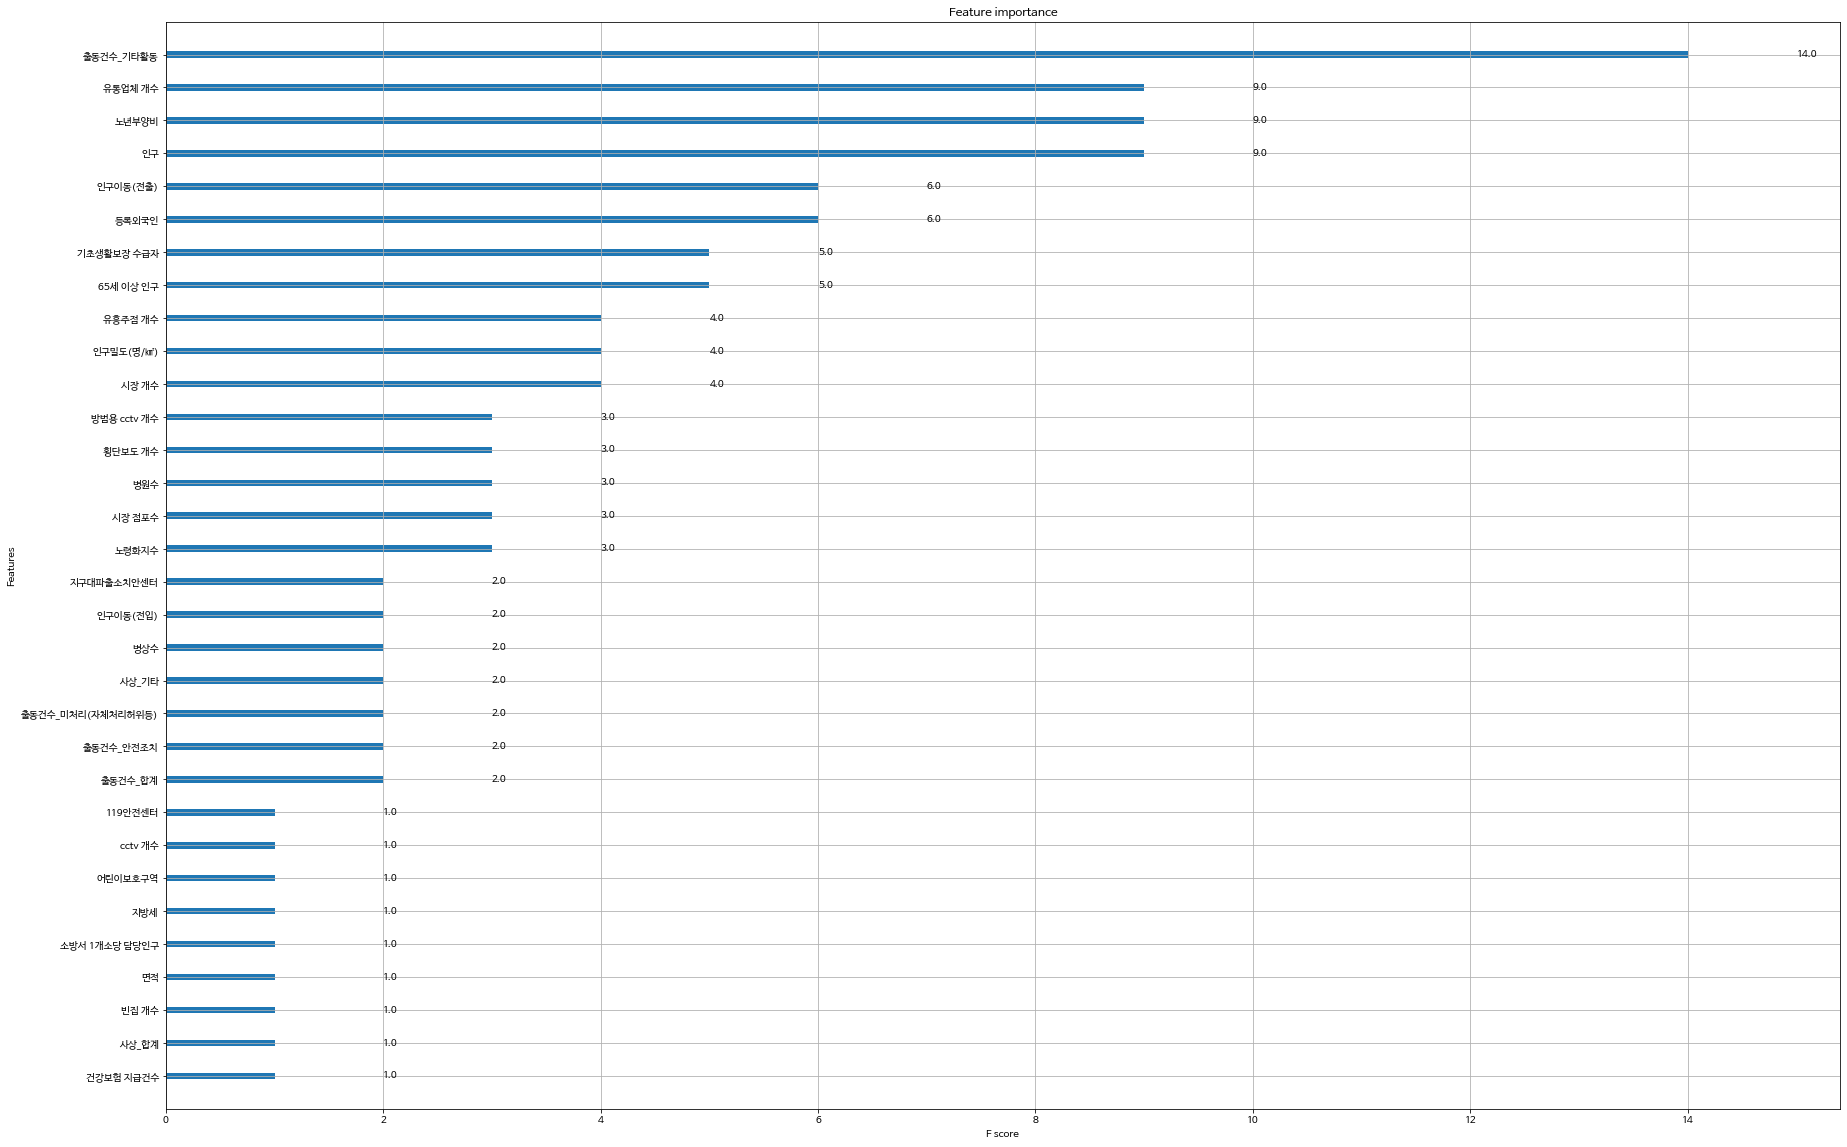

In [34]:
ax = xgb.plot_importance(xgb_classify)
fig = ax.figure
plt.rc('font', family='NanumBarunGothic')
fig.set_size_inches(30,20)

# CNN

XGBoost를 통해 변수들의 Feature Importance를 알아본 뒤에는 로드뷰 사진을 가지고 CNN으로 범죄위험도를 예측해보았습니다. 이전 과제에서와 비슷하게 CNN의 성능은 그리 좋지 않았습니다. 

## Make Labels

이전에 총 7개년의 5대 범죄 합계 데이터가 있었으며 이 중 상위 50%에 대해 unsafe라는 레이블을 달아주었었습니다. 그리고 총 7개년에 대해 unsafe 레이블이 있었던 구를 count 했고, 4년 이상 unsafe 레이블을 가지고 있던 12개의 구에 대해 unsafe 레이블을 달아주었습니다. 

In [10]:
unsafe = data.loc[data['범죄위험도']=='unsafe']['자치구']
unsafe_gu = []
for i in unsafe :
  unsafe_gu.append(i.split('_')[0])
Counter(unsafe_gu)

Counter({'강남구': 7,
         '강동구': 4,
         '강서구': 7,
         '관악구': 7,
         '광진구': 4,
         '구로구': 6,
         '노원구': 3,
         '동대문구': 3,
         '마포구': 6,
         '서초구': 7,
         '성북구': 1,
         '송파구': 7,
         '양천구': 2,
         '영등포구': 7,
         '은평구': 3,
         '종로구': 3,
         '중구': 4,
         '중랑구': 6})

In [11]:
unsafe_gu_list = []
gu_count = Counter(unsafe_gu)
for i in gu_count :
  if gu_count[i] > 3 :
    unsafe_gu_list.append(i)
unsafe_gu_list

['중구',
 '광진구',
 '중랑구',
 '마포구',
 '강서구',
 '구로구',
 '영등포구',
 '관악구',
 '서초구',
 '강남구',
 '송파구',
 '강동구']

## Prepare Data for CNN

### Prepare Image File Path

이미지 파일 경로 및 구 이름으로 데이터프레임을 만들어줍니다. 

In [12]:
from pathlib import Path

base_path = Path('/content/drive/MyDrive/AI 경제정보처리/cropped_img_data')
path_list = []

for folder in base_path.iterdir() :    
    for file in folder.iterdir() :
        path_list.append([file,file.stem.split('_')[0]])

file_path = pd.DataFrame(path_list, columns=['Path','GU'])
file_path.head()

,Path,GU
0,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_0.png,Dobong
1,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_1.png,Dobong
2,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_38.png,Dobong
3,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_16.png,Dobong
4,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_27.png,Dobong


### Merge Dataframes

구 이름(한글), 구 이름(영어), 범죄위험도 이 세개의 columns을 가진 데이터프레임을 만든 후 이미지 파일 경로 데이터프레임과 merge 시켜 주었습니다.

In [13]:
seoul = {'강남구':'Gangnam','강동구':'Gangdong','강북구':'Gangbuk','강서구':'Gangseo',
        '관악구':'Gwanak','광진구':'Gwangjin','구로구':'Guro','금천구':'Geumcheon',
        '노원구':'Nowon','도봉구':'Dobong','동대문구':'Dongdaemun','동작구':'Dongjak',
        '마포구':'Mapo','서대문구':'Seodaemun','서초구':'Seocho','성동구':'Seongdong',
        '성북구':'Seongbuk','송파구':'Songpa','양천구':'Yangcheon','영등포구':'Yeongdeungpo',
        '은평구':'Eunpyeong', '종로구':'Jongno','중구':'Jung','중랑구':'Jungnang',
        '용산구':'Yongsan'}

In [14]:
unsafe_gu_dict = dict()
for i in seoul.keys() :
  if i in unsafe_gu_list : 
    unsafe_gu_dict[i] = 'unsafe'
  else :
    unsafe_gu_dict[i] = 'safe'
unsafe_gu_dict

{'강남구': 'unsafe',
 '강동구': 'unsafe',
 '강북구': 'safe',
 '강서구': 'unsafe',
 '관악구': 'unsafe',
 '광진구': 'unsafe',
 '구로구': 'unsafe',
 '금천구': 'safe',
 '노원구': 'safe',
 '도봉구': 'safe',
 '동대문구': 'safe',
 '동작구': 'safe',
 '마포구': 'unsafe',
 '서대문구': 'safe',
 '서초구': 'unsafe',
 '성동구': 'safe',
 '성북구': 'safe',
 '송파구': 'unsafe',
 '양천구': 'safe',
 '영등포구': 'unsafe',
 '용산구': 'safe',
 '은평구': 'safe',
 '종로구': 'safe',
 '중구': 'unsafe',
 '중랑구': 'unsafe'}

In [15]:
unsafe_gu_df = pd.DataFrame(unsafe_gu_dict.items(), columns=['구','범죄위험도'])
unsafe_gu_df['구_영어'] = unsafe_gu_df['구'].map(seoul)
unsafe_gu_df

,구,범죄위험도,구_영어
0,강남구,unsafe,Gangnam
1,강동구,unsafe,Gangdong
2,강북구,safe,Gangbuk
3,강서구,unsafe,Gangseo
4,관악구,unsafe,Gwanak
5,광진구,unsafe,Gwangjin
6,구로구,unsafe,Guro
7,금천구,safe,Geumcheon
8,노원구,safe,Nowon
9,도봉구,safe,Dobong


In [16]:
crime_df = file_path.merge(unsafe_gu_df, how='left', left_on='GU', right_on='구_영어')
crime_df.drop('구_영어', axis=1, inplace=True)
crime_df.head()

,Path,GU,구,범죄위험도
0,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_0.png,Dobong,도봉구,safe
1,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_1.png,Dobong,도봉구,safe
2,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_38.png,Dobong,도봉구,safe
3,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_16.png,Dobong,도봉구,safe
4,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dobong/Dobong_crop_27.png,Dobong,도봉구,safe


### Split Train/Test Set

CNN으로 학습시킬 이미지를 train과 test로 나누어주었습니다. 이후에 test set은 앙상블 학습에 이용해야하기 때문에 전체 데이터셋의 50%만 CNN 학습에 이용하였습니다. 

In [17]:
y = crime_df['범죄위험도']
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(crime_df, y, test_size=0.5, random_state=42, stratify=y)

In [18]:
X_train_img['is_valid'] = False
X_test_img['is_valid'] = True

img_combined_fastai = pd.concat([X_train_img, X_test_img], axis=0)
img_combined_fastai

,Path,GU,구,범죄위험도,is_valid
1854,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Seocho/Seocho_crop_19.png,Seocho,서초구,unsafe,False
893,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Geumcheon/Geumcheon_crop_48.png,Geumcheon,금천구,safe,False
2466,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Yeongdeungpo/Yeongdeungpo_crop_23.png,Yeongdeungpo,영등포구,unsafe,False
2411,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Yangcheon/Yangcheon_crop_43.png,Yangcheon,양천구,safe,False
2181,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Seongdong/Seongdong_crop_26.png,Seongdong,성동구,safe,False
...,...,...,...,...,...
999,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dongdaemun/Dongdaemun_crop_59.png,Dongdaemun,동대문구,safe,True
2002,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Jungnang/Jungnang_crop_87.png,Jungnang,중랑구,unsafe,True
883,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Geumcheon/Geumcheon_crop_36.png,Geumcheon,금천구,safe,True
1413,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Seongbuk/Seongbuk_crop_36.png,Seongbuk,성북구,safe,True


### Make DataLoaders

In [33]:
from fastai.vision.data import ImageDataLoaders

In [34]:
my_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(), # split train and valid sets using 'is_valid'
    get_x=ColReader(0), # use image path from the first column of the df
    get_y=ColReader(3), # use label from the fourth column of the df
    item_tfms=Resize(128))

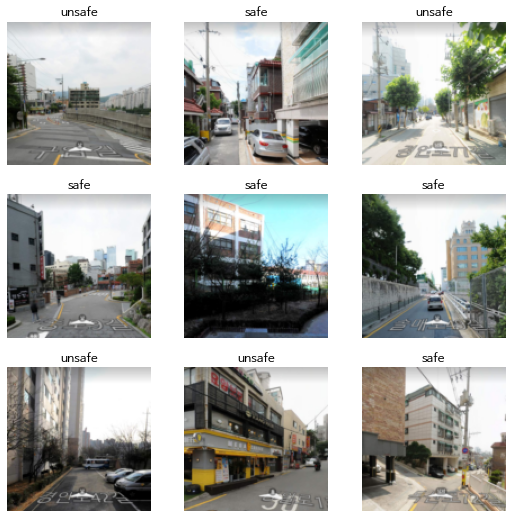

In [35]:
# prepare dataloaders and show batch

dls = my_dblock.dataloaders(img_combined_fastai)
dls.show_batch()

## Learn CNN Model

In [36]:
learn = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=5),SaveModelCallback(monitor='accuracy')])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.294314,1.108443,0.520270,06:02


Better model found at epoch 0 with accuracy value: 0.5202702879905701.


epoch,train_loss,valid_loss,accuracy,time
0,0.909911,0.993224,0.522523,00:49
1,0.783457,0.972285,0.516517,00:48
2,0.658129,1.001947,0.526276,00:48
3,0.547946,1.066109,0.518018,00:50
4,0.441032,1.166199,0.516517,00:48
5,0.344648,1.321826,0.530030,00:48
6,0.260102,1.400610,0.507508,00:48
7,0.194888,1.530673,0.511261,00:50
8,0.144751,1.677596,0.521772,00:49
9,0.107938,1.772524,0.518769,00:48


Better model found at epoch 0 with accuracy value: 0.522522509098053.
Better model found at epoch 2 with accuracy value: 0.5262762904167175.
Better model found at epoch 5 with accuracy value: 0.5300300121307373.
No improvement since epoch 5: early stopping


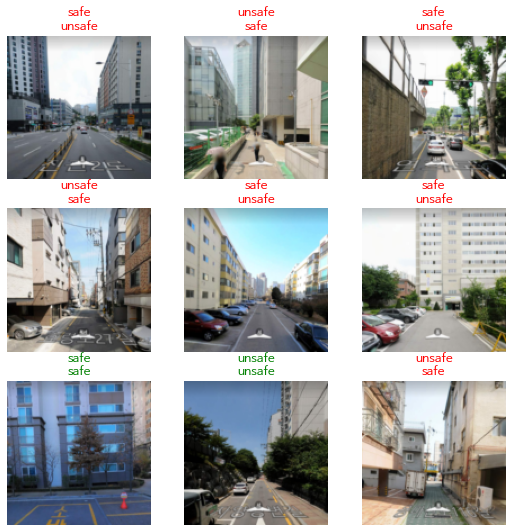

In [37]:
learn.show_results()

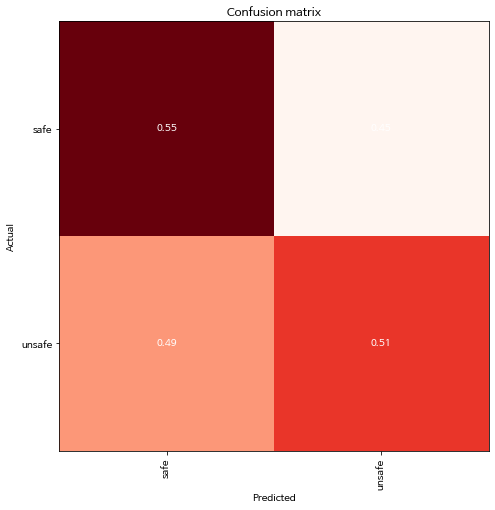

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, cmap='Reds', figsize=(7,7))

In [39]:
# get predicted probability for valid set

y_pred_valid_cnn_proba, y_pred_valid_cnn_true = learn.get_preds(dl=dls.valid, with_input=False)
y_pred_valid_cnn_proba

TensorBase([[0.8685, 0.1315],
        [0.3975, 0.6025],
        [0.2211, 0.7789],
        ...,
        [0.6341, 0.3659],
        [0.8200, 0.1800],
        [0.0086, 0.9914]])

In [40]:
# if prob. of being class=1 is more than 0.5 (50%), predicted class for the image is class 1

y_pred_valid_cnn_proba2 = y_pred_valid_cnn_proba[:,1]

y_pred_valid_cnn = [1 if i >= 0.5 else 0 for i in y_pred_valid_cnn_proba2]
print(y_pred_valid_cnn)

[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 

In [21]:
le = LabelEncoder()
y_test_img = le.fit_transform(y_test_img)
le.classes_

array(['safe', 'unsafe'], dtype=object)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_img, y_pred_valid_cnn))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       685
           1       0.52      0.51      0.51       647

    accuracy                           0.53      1332
   macro avg       0.53      0.53      0.53      1332
weighted avg       0.53      0.53      0.53      1332



# Ensemble

위에서 CNN을 학습시켜 나온 결과 및 XGBoost로 얻은 주요 변수 12개로 범죄 위험도를 예측하는 앙상블 모델을 만들었습니다. 앙상블 모델로는 로지스틱 회귀를 사용하였으며 종속 변수는 범죄 위험도, 독립변수는 CNN학습 결과 및 XGBoost feature importance 상위 12개 변수입니다. 

## Make Dataframe

XGBoost feature importance 상위 12개 변수 및 cnn 학습 결과를 합친 데이터프레임을 만들어주었습니다. 학습에 사용된 로드뷰는 모두 2020년 사진이었으므로 2020년 데이터만 가져와서 cnn 결과와 merge 시켜주었습니다. 그래서 만들어진 최종 데이터프레임은 ensemble_df 입니다. 

In [23]:
df  = data[['자치구', '출동건수_기타활동','유통업체 개수','노년부양비','인구','노년부양비','시장 개수','유흥주점 개수',
            '기초생활보장 수급자', '등록외국인','인구이동(전출)','65세 이상 인구','인구밀도(명/㎢)']]
df = df.iloc[150:, :]  # 학습한 로드뷰는 모두 2020년 사진이므로 2020년 데이터만 사용
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
df.head()

,자치구,출동건수_기타활동,유통업체 개수,노년부양비,인구,노년부양비,시장 개수,유흥주점 개수,기초생활보장 수급자,등록외국인,인구이동(전출),65세 이상 인구,인구밀도(명/㎢)
0,종로구_2020,112.0,13.0,23.3,158996.0,23.3,21.0,435.0,5232.0,10767.0,25254.0,28073.0,6649.0
1,중구_2020,93.0,53.0,23.4,134635.0,23.4,40.0,648.0,5299.0,10294.0,21733.0,23794.0,13517.0
2,용산구_2020,172.0,13.0,21.5,244645.0,21.5,7.0,88.0,8265.0,16586.0,38985.0,39439.0,11188.0
3,성동구_2020,104.0,13.0,19.3,300505.0,19.3,9.0,33.0,9718.0,8151.0,53096.0,44728.0,17822.0
4,광진구_2020,194.0,19.0,17.3,360109.0,17.3,14.0,26.0,11864.0,15573.0,60703.0,48989.0,21105.0


In [24]:
df['구'] = 0
for i in range(len(df)) :
  df.iloc[i,13] = df['자치구'][i].split('_')[0]
df.head()

,자치구,출동건수_기타활동,유통업체 개수,노년부양비,인구,노년부양비,시장 개수,유흥주점 개수,기초생활보장 수급자,등록외국인,인구이동(전출),65세 이상 인구,인구밀도(명/㎢),구
0,종로구_2020,112.0,13.0,23.3,158996.0,23.3,21.0,435.0,5232.0,10767.0,25254.0,28073.0,6649.0,종로구
1,중구_2020,93.0,53.0,23.4,134635.0,23.4,40.0,648.0,5299.0,10294.0,21733.0,23794.0,13517.0,중구
2,용산구_2020,172.0,13.0,21.5,244645.0,21.5,7.0,88.0,8265.0,16586.0,38985.0,39439.0,11188.0,용산구
3,성동구_2020,104.0,13.0,19.3,300505.0,19.3,9.0,33.0,9718.0,8151.0,53096.0,44728.0,17822.0,성동구
4,광진구_2020,194.0,19.0,17.3,360109.0,17.3,14.0,26.0,11864.0,15573.0,60703.0,48989.0,21105.0,광진구


In [25]:
df['구_영어'] = df['구'].map(seoul)
df.head()

,자치구,출동건수_기타활동,유통업체 개수,노년부양비,인구,노년부양비,시장 개수,유흥주점 개수,기초생활보장 수급자,등록외국인,인구이동(전출),65세 이상 인구,인구밀도(명/㎢),구,구_영어
0,종로구_2020,112.0,13.0,23.3,158996.0,23.3,21.0,435.0,5232.0,10767.0,25254.0,28073.0,6649.0,종로구,Jongno
1,중구_2020,93.0,53.0,23.4,134635.0,23.4,40.0,648.0,5299.0,10294.0,21733.0,23794.0,13517.0,중구,Jung
2,용산구_2020,172.0,13.0,21.5,244645.0,21.5,7.0,88.0,8265.0,16586.0,38985.0,39439.0,11188.0,용산구,Yongsan
3,성동구_2020,104.0,13.0,19.3,300505.0,19.3,9.0,33.0,9718.0,8151.0,53096.0,44728.0,17822.0,성동구,Seongdong
4,광진구_2020,194.0,19.0,17.3,360109.0,17.3,14.0,26.0,11864.0,15573.0,60703.0,48989.0,21105.0,광진구,Gwangjin


In [26]:
X_test_img['cnn'] = y_pred_valid_cnn
X_test_img

,Path,GU,구,범죄위험도,is_valid,cnn
796,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Gangdong/Gangdong_crop_59.png,Gangdong,강동구,unsafe,True,0
2354,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Songpa/Songpa_crop_93.png,Songpa,송파구,unsafe,True,1
561,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Gangseo/Gangseo_crop_21.png,Gangseo,강서구,unsafe,True,1
519,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Guro/Guro_crop_19.png,Guro,구로구,unsafe,True,0
1955,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Jungnang/Jungnang_crop_35.png,Jungnang,중랑구,unsafe,True,1
...,...,...,...,...,...,...
999,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Dongdaemun/Dongdaemun_crop_59.png,Dongdaemun,동대문구,safe,True,0
2002,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Jungnang/Jungnang_crop_87.png,Jungnang,중랑구,unsafe,True,1
883,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Geumcheon/Geumcheon_crop_36.png,Geumcheon,금천구,safe,True,0
1413,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Seongbuk/Seongbuk_crop_36.png,Seongbuk,성북구,safe,True,0


In [27]:
ensemble_df = pd.merge(X_test_img, df, how='left', left_on='GU', right_on='구_영어')
ensemble_df.drop(['구_x','구_y','자치구','구_영어','is_valid'],axis=1,inplace=True)
ensemble_df.head()

,Path,GU,범죄위험도,cnn,출동건수_기타활동,유통업체 개수,노년부양비,인구,노년부양비,시장 개수,유흥주점 개수,기초생활보장 수급자,등록외국인,인구이동(전출),65세 이상 인구,인구밀도(명/㎢)
0,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Gangdong/Gangdong_crop_59.png,Gangdong,unsafe,0,112.0,12.0,19.7,463998.0,19.7,8.0,288.0,14698.0,4396.0,78271.0,66401.0,18869.0
1,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Songpa/Songpa_crop_93.png,Songpa,unsafe,1,219.0,22.0,17.6,673926.0,17.6,7.0,202.0,16081.0,6788.0,116457.0,89539.0,19896.0
2,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Gangseo/Gangseo_crop_21.png,Gangseo,unsafe,1,106.0,15.0,19.3,585901.0,19.3,11.0,224.0,27797.0,6401.0,99573.0,85992.0,14140.0
3,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Guro/Guro_crop_19.png,Guro,unsafe,0,96.0,23.0,20.8,432488.0,20.8,9.0,75.0,12329.0,32471.0,64024.0,67432.0,21496.0
4,/content/drive/MyDrive/AI 경제정보처리/cropped_img_data/Jungnang/Jungnang_crop_35.png,Jungnang,unsafe,1,141.0,14.0,22.5,399562.0,22.5,13.0,46.0,24833.0,5059.0,62212.0,66764.0,21603.0


## Logistic Regression

CNN 학습결과 및 XGBoost로 얻은 중요 변수 12개를 독립변수로, 범죄위험도를 종속변수로 하는 로지스틱 회귀 모델로 학습 및 예측을 진행하였습니다. test data set에 대한 accuracy는 0.8175로 cnn 학습 결과였던 accuracy 0.53 보다 대폭 상승하였으며 이것은 기존 연구에서 문제점으로 지적되던 로드뷰 사진에 지역적인 정보가 포함되어있지 않았던 문제를 해결함으로써 가능했던 결과였다고 판단합니다. 다만 CNN 학습 결과를 중요 변수 12개에 추가시켰을 때의 marginal effect가 미미했던 것으로 보아 로드뷰 사진 자체에는 큰 한계가 존재했던 것 같습니다. 

In [28]:
X = ensemble_df.drop(['Path','GU','범죄위험도'],axis=1)
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, ensemble_df['범죄위험도'], test_size=0.3, random_state=42)
print(X_train_ensemble.shape, X_test_ensemble.shape, y_train_ensemble.shape, y_test_ensemble.shape)

(932, 13) (400, 13) (932,) (400,)


In [29]:
model = LogisticRegression()
model.fit(X_train_ensemble, y_train_ensemble)
print('accuracy of train set :',model.score(X_train_ensemble,y_train_ensemble))
print('accuracy of test set :',model.score(X_test_ensemble,y_test_ensemble))

accuracy of train set : 0.8369098712446352
accuracy of test set : 0.8175


In [30]:
print(model.coef_)

[[-2.72676943e-06  3.40959643e-04  3.32531455e-04 -3.91458898e-05
   2.85958556e-05 -3.91458898e-05  2.08141637e-04  3.89463110e-03
   2.56770768e-04  1.38214600e-04  1.67225174e-04 -4.22979257e-04
  -1.48787081e-04]]


In [31]:
y_preds = model.predict(X_test_ensemble)
print(classification_report(y_test_ensemble, y_preds))

              precision    recall  f1-score   support

        safe       0.79      0.83      0.81       189
      unsafe       0.84      0.81      0.82       211

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



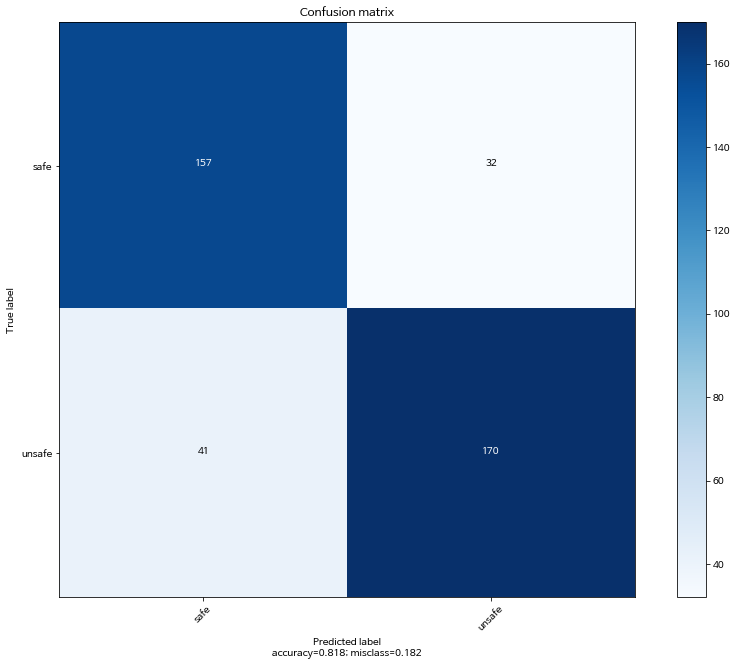

In [54]:
conf_mx = confusion_matrix(y_test_ensemble, y_preds)

# plot confusion matrix (raw)

my_classes = ['safe','unsafe']
plot_confusion_matrix(conf_mx, my_classes, cmap=None, normalize=False)